In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import tensorflow as tf
import pathlib
import glob

In [3]:
pwd = os.getcwd()
images_dir = str(pwd) + '\\images\\content\\'
dir = pathlib.Path(images_dir)

0


In [4]:
print(images_dir)

C:\Users\josh.dykstra\Desktop\Jupyter Notebooks\Color Polygon Images\archive (4)\images\content\


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir, image_size=(180, 180), batch_size=64
)

Found 10000 files belonging to 4 classes.


In [6]:
targets_file = str(pwd) + '\\targets.csv'
pd.read_csv(targets_file)

,Unnamed: 0,filename,sides,bg_color,fg_color,bound_circle_x,bound_circle_y,bound_circle_r,rotation
0,0,70aaa621-1345-4541-a954-ee9856daaf18.png,4,blue,pink,29,39,15,185
1,1,ea0d8d14-596a-4365-b007-6325fc96e0f4.png,3,black,yellow,66,66,21,215
2,2,48c1fc5a-8b6b-4555-bb6a-a7d42a5cedc2.png,4,yellow,red,59,103,20,59
3,3,ad721906-604c-4682-ae5d-15539ef1dbc7.png,3,green,pink,65,66,61,272
4,4,510dd5ea-fb92-432e-91cc-ed4654a03ebd.png,6,white,green,48,56,42,38
...,...,...,...,...,...,...,...,...,...
9995,9995,e921970a-e09d-4760-ab46-9a33f863d1ef.png,5,green,pink,79,58,43,322
9996,9996,bf398918-a475-42f1-adc0-59497120bcbd.png,3,green,pink,66,63,57,47
9997,9997,c4065a6d-5339-46f5-9917-2831698d4fb8.png,6,pink,black,64,67,62,125
9998,9998,afd51b22-725a-4c43-8b40-dba5a83952c4.png,3,black,gray,25,20,14,28


In [7]:
batch_size = 32
img_height = 128
img_width = 128

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 4 classes.
Using 8000 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 4 classes.
Using 2000 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['hexagon', 'pentagon', 'square', 'triangle']


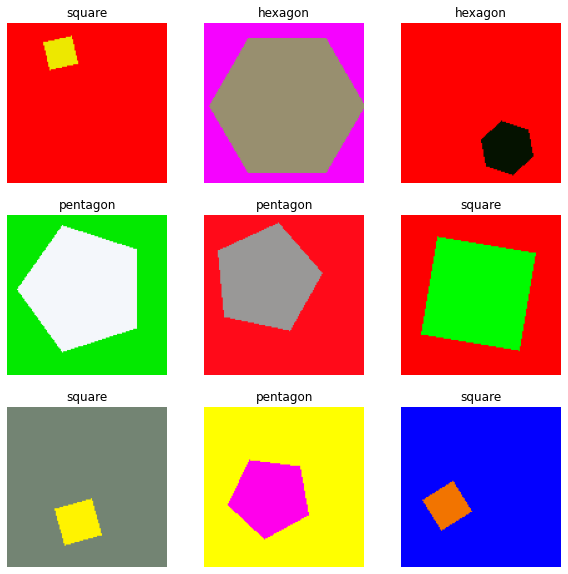

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 42s 166ms/step - loss: 1.2947 - accuracy: 0.3613 - val_loss: 1.1616 - val_accuracy: 0.4555
Epoch 2/10
250/250 [==============================] - 43s 172ms/step - loss: 0.9908 - accuracy: 0.5495 - val_loss: 0.8544 - val_accuracy: 0.6260
Epoch 3/10
250/250 [==============================] - 44s 177ms/step - loss: 0.6661 - accuracy: 0.7190 - val_loss: 0.6429 - val_accuracy: 0.7305
Epoch 4/10
250/250 [==============================] - 43s 172ms/step - loss: 0.4631 - accuracy: 0.8117 - val_loss: 0.5629 - val_accuracy: 0.7710
Epoch 5/10
250/250 [==============================] - 47s 188ms/step - loss: 0.3284 - accuracy: 0.8685 - val_loss: 0.5328 - val_accuracy: 0.7985
Epoch 6/10
250/250 [==============================] - 46s 182ms/step - loss: 0.2307 - accuracy: 0.9125 - val_loss: 0.5740 - val_accuracy: 0.7905
Epoch 7/10
250/250 [==============================] - 45s 179ms/step - loss: 0.1531 - accuracy: 0.9429 - val_loss: 0.6678 - val_ac

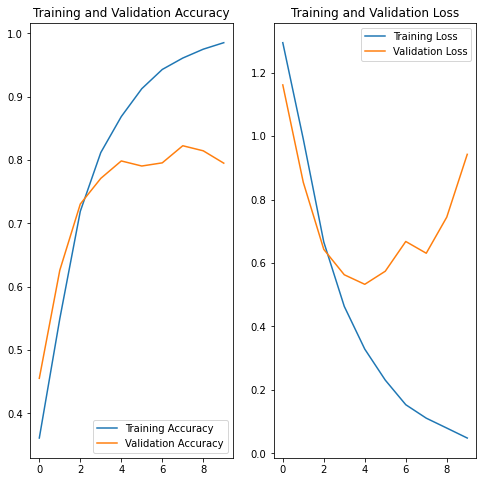

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

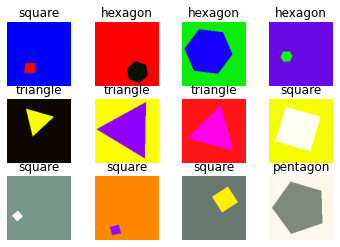

In [27]:
files = glob.glob(str(pwd)+"\\test_images\\*.png")
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img_dir = files[i]
    data = image.imread(img_dir)
    plt.imshow(data)
    img = tf.keras.utils.load_img(
    img_dir, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label = class_names[np.argmax(score)]

    plt.title(label)
    plt.axis("off")